In [1]:
!pip install transformers evaluate sentencepiece nltk rouge-score
!git clone https://github.com/ChaitaliV/generative-explanation;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=bc5609d9a04135d4c5e224378cec561844db5f131ebace54eba1dbd08ffa5a81
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Cloning into 'generative-explanation'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 158 (delta 33), reused 3 (delta 3), pack-reused 96
Receiving obj

In [2]:
import torch
import requests
import json
import pandas as pd
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import evaluate
from datasets import load_metric
import numpy as np
import nltk
import matplotlib.pyplot as plt

## Get Data

In [3]:
df = pd.read_csv('generative-explanation/datasets/supervised_data.csv')
df.head()

,Unnamed: 0,text,label,explanation
0,0,"I run the machine for the jeans etc., which ar...",0.0,i
1,1,"Apart from this, sir, after doing normal work ...",0.0,i
2,2,"Sir, income is work in contract, Sir what happ...",0.0,i
3,3,Almost in a month - there is work according to...,0.0,i
4,4,my name is Sonu.,0.0,i


In [5]:
df = df.dropna()

In [11]:
# Define replacements
replacement_dict = {
    'i': 'The sentence does not show any depression symptoms or stress',
    'w/f': 'Patient has stressfule environment around them, which might contribute to higher stress and depression',
    'h': 'Pateint has history of depression and/or has taken mediction for the same',
    'c': 'Patient might have depression, but the context is required for proper diagnosis'
}

# Replace values in the 'column_name' column using replace()
df['explanation'] = df['explanation'].replace(replacement_dict)

In [12]:
df

,Unnamed: 0,text,label,explanation
0,0,"I run the machine for the jeans etc., which ar...",0.0,The sentence does not show any depression symp...
1,1,"Apart from this, sir, after doing normal work ...",0.0,The sentence does not show any depression symp...
2,2,"Sir, income is work in contract, Sir what happ...",0.0,The sentence does not show any depression symp...
3,3,Almost in a month - there is work according to...,0.0,The sentence does not show any depression symp...
4,4,my name is Sonu.,0.0,The sentence does not show any depression symp...
...,...,...,...,...
2000,2000,We will be married for 36 years,0.0,The sentence does not show any depression symp...
2001,2001,"Since January 31st, I am here.",0.0,The sentence does not show any depression symp...
2002,2002,"There is a daughter at home, a son, married he...",0.0,The sentence does not show any depression symp...
2003,2003,Will turn 12 on January 19.,0.0,The sentence does not show any depression symp...


## Initialization

In [19]:
tokenizer = T5TokenizerFast.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base", return_dict=True)
device = 'cuda:0'
pattern_len = 218
response_len = 218
batch_size = 8
epochs = 5
optimizer = AdamW(model.parameters(), lr=0.0001)

## Prepare Data
* load the dataset
* since it is seq2seq model pre-training, I used T5 tokenizer and created, input_ids and attention masks for encoder, and used labels for decoder(labels are basically input_ids of tokenized target text, I didn't use attention_mask of decoder due to GPU running out of memory during training, but labels are capable of getting decoder attention_masks for T5 model while training so it's okay.)
* Then I created train-test split on the data, with 0.1 data used for validation, since the dataset is small, I am not taking out "test" data, coz focus is on training method, rather than checking final accuracy on test data.
* created dataloaders for both training data and validation data

In [22]:
class Prepare_Data():
  """
  this class will take the dataframe and,
  -- tokenize the text, get input_ids, attention_masks, and labels
  -- make train-validation split
  -- create dataloaders for training and validation data
  """
  def __init__(self, tokenizer, dframe, q_len, t_len):
    self.tokenizer = tokenizer
    self.p_len = pattern_len
    self.r_len = response_len
    self.data = dframe
    self.sentences = self.data.text.values
    self.responses = self.data.explanation.values

  def prepare_dataloader(self):
    # tokenize pattern + tag (as input features- encoder)
    pattern_tokenized = self.tokenizer([str(sequence) for sequence in self.sentences], max_length=self.p_len, padding="max_length",
                                                    truncation=True, pad_to_max_length=True, add_special_tokens=True,return_tensors="pt")

    # tokenize target response(as target - decoder)
    response_tokenized = self.tokenizer([str(response) for response in self.responses], max_length=self.r_len, padding="max_length",
                                          truncation=True, pad_to_max_length=True, add_special_tokens=True, return_tensors = "pt")


    ## get labels, input_ids, and attention_mask
    labels = response_tokenized.input_ids
    labels[labels == tokenizer.pad_token_id] = -100
    input_ids = pattern_tokenized.input_ids
    attention_mask = pattern_tokenized.attention_mask

    #create train, validation split
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,random_state = 2018, test_size = 0.1 )
    train_masks, validation_masks, _, _ = train_test_split(attention_mask, input_ids,
                                             random_state=2018, test_size=0.1)

    #create dataloaders for training and validation data
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    return train_dataloader, validation_dataloader

In [23]:
LoadData = Prepare_Data(tokenizer, df, pattern_len, response_len)
train_dataloader, validation_dataloader = LoadData.prepare_dataloader()

## Train the Model
* used Adam optmizer for this task
* trained the model on training dataset, and then evaluated it in validation dataset

In [24]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [25]:
# The Training Loop
t = []
# Store our loss and accuracy for plotting
train_loss_set = []
val_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  #set model in training mode
  model.train()

  #tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    #forward pass
    outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    #backward pass
    loss.backward()
    #update parameters and take a step using the computed gradient
    optimizer.step()

    #update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  train_loss = tr_loss/nb_tr_steps
  train_loss_set.append(train_loss)

  print("Train loss: {}".format(train_loss))


  # Evaluation

  #put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  #tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  #evaluate data for one epoch
  for batch in validation_dataloader:
    #add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    #unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    e_loss = outputs['loss']

    #calculate loss for the whole batch
    eval_loss += e_loss.item()
    nb_eval_steps += 1

  val_loss = eval_loss/nb_eval_steps
  val_loss_set.append(val_loss)

  print("Validation loss: {}".format(val_loss))


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.6720536932250304


Epoch:  20%|██        | 1/5 [03:12<12:48, 192.09s/it]

Validation loss: 0.14960557233112362
Train loss: 0.14364320127936328


Epoch:  40%|████      | 2/5 [06:27<09:42, 194.18s/it]

Validation loss: 0.12757683205060089
Train loss: 0.11585732415705853


Epoch:  60%|██████    | 3/5 [09:43<06:29, 194.84s/it]

Validation loss: 0.12719245477078053
Train loss: 0.0957650776161293


Epoch:  80%|████████  | 4/5 [12:59<03:15, 195.18s/it]

Validation loss: 0.1277692115579087
Train loss: 0.0789295048638354


Epoch: 100%|██████████| 5/5 [16:14<00:00, 194.94s/it]

Validation loss: 0.1340424531372264


In [26]:
len(val_loss_set)

5

[]

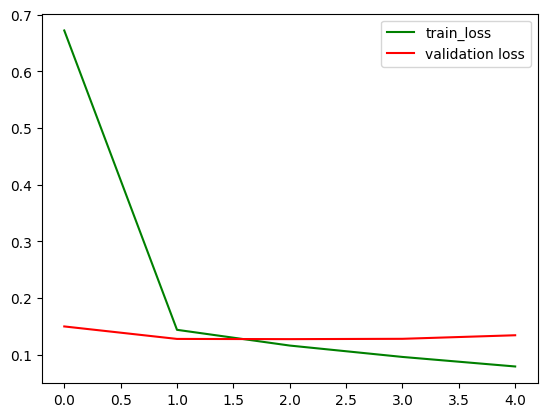

In [27]:
plt.plot(np.arange(0, len(train_loss_set)), train_loss_set, color = 'g', label = 'train_loss')
plt.plot(np.arange(0,len(val_loss_set)), val_loss_set, color = 'r', label = 'validation loss')
plt.legend()
plt.plot()

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
torch.save(model,r'/content/drive/MyDrive/T5_wo_pretraining.pt')

## Make Inference


In [30]:
model = torch.load(r'/content/drive/MyDrive/T5_wo_pretraining.pt')

In [31]:
model.to('cpu')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [32]:
def infer(pattern):
  inputs = tokenizer(pattern, max_length=pattern_len, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")
  input_ids = inputs.input_ids
  outputs = model.generate(input_ids=input_ids)
  predicted_answer = tokenizer.decode(outputs.flatten(), skip_special_tokens=True)
  return predicted_answer

In [36]:
infer('I feel sad all the time')

'The person is showing clear signs of depression, such as sadness'

In [40]:
infer("I am tired all the time and I am sleeping a lot, I do not know what's wrong")

'The person is showing clear signs of depression, such as trouble with sleep'

In [42]:
infer("I love cats, they make me happy")

'The sentence does not show any depression symptoms or stress'

In [44]:
infer('I was on medication for depression last year')

'Pateint has history of depression and/or has taken mediction for the same'

In [47]:
infer('People around me are so toxic, I just want to die')

'The person is showing clear signs of depression, such as suicidal thoughts'